In [ ]:
# conditioning on the time will require
# some special attention becuase the number of training
# points explodes
# N_theta * N_times = O(1e9) or even bigger....

# so here lets try input theta and output waveform for all times.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [2]:
import datetime
import os
import numpy as np
import math

import waveform
import sample
import model_utils
import dataset

2022-07-12 12:12:48.160426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 12:12:48.160487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import wispy.callbacks

In [4]:
# from model_utils import PoisonPillCallback

In [5]:
import pandas as pd

In [6]:
import tensorflow as tf

In [7]:
import pycbc.pnutils

In [8]:
import lalsimulation as lalsim

In [9]:
import sklearn.preprocessing

In [10]:
plt.rcParams.update({'font.size':16})

# generate waveform data

In [157]:
def gen_waveform_set(train_test_val, n_samples, nproc=1, mass_ratio_low=1, mass_ratio_high=8, return_data='hp_hc'):
    assert train_test_val in ['train', 'val']
    
    # approximant="IMRPhenomXHM"
    # approximant="IMRPhenomXPHM"
    # approximant="SEOBNRv4PHM"
    # approximant="IMRPhenomXAS"
    # approximant="SEOBNRv4_opt"
    # approximant="SEOBNRv4P"
    # approximant="SEOBNRv4P"
    approximant="IMRPhenomXP"
    # approximant="IMRPhenomD"
    # approximant="IMRPhenomHM"

    # uniform spacing throughout
    t1 = -2000
    # t1 = -500
    # t1 = -200
    # t1 = -50
    
    # t1 = -50
    t2 = 70
    # t1 = -10
    # t2 = 20
    dt = 0.25
    new_times_M = np.arange(t1, t2, dt)

    t_idxs = np.arange(len(new_times_M))
    # t_training_idxs = None
    # t_validation_idxs = None
    if train_test_val == "train":
        t_idxs_sample = t_idxs[::2]
    elif train_test_val == "val":
        # t_idxs_sample = t_idxs[1::2]
        t_idxs_sample = t_idxs[::2]

    total_mass=100
    distance_mpc=1
    delta_t=1/4096
    f_lower=10
    
    # out = sample.draw_mass_ratio_inc_coa_phase_samples(n_samples, mass_ratio_low, mass_ratio_high)
    # out = sample.draw_inc_coa_phase_samples(n_samples, mass_ratio=1)
    out = sample.draw_9d_samples(n_samples, mass_ratio_low=1, mass_ratio_high=2)
    # out = sample.draw_mass_ratio_samples(n_samples, mass_ratio_low, mass_ratio_high)
    mass_ratios = out[0]
    # spin1xs = out[1]
    # spin1ys = out[2]
    spin1xs = np.zeros_like(out[1])
    spin1ys = np.zeros_like(out[2])
    # spin1zs = out[3]
    spin1zs = np.zeros_like(out[3])
    # spin2xs = out[4]
    # spin2ys = out[5]
    spin2xs = np.zeros_like(out[4])
    spin2ys = np.zeros_like(out[5])
    # spin2zs = out[6]
    spin2zs = np.zeros_like(out[6])
    coa_phases = out[7]
    # coa_phases = np.zeros_like(out[7])
    inclinations = out[8]
    # inclinations = np.zeros_like(out[8])
    # inclinations = np.zeros_like(out[8]) + np.pi/2.1
    # inclinations = np.zeros_like(out[8]) + np.pi/1.9
    # inclinations = np.zeros_like(out[8]) + (5 * 180/np.pi)
    
    # mass_ratios = np.zeros(n_samples) + 4
    # # spin1xs = np.random.uniform(0, 0.99, n_samples)
    # spin1xs = np.zeros(n_samples) + 0.99
    # spin1ys = np.zeros(n_samples)
    # spin1zs = np.zeros(n_samples)
    # spin2xs = np.zeros(n_samples)
    # spin2ys = np.zeros(n_samples)
    # spin2zs = np.zeros(n_samples)
    # coa_phases = np.zeros(n_samples)
    # # inclinations = np.zeros(n_samples)
    # inclinations = np.random.uniform(0, np.pi, n_samples)
    

    starttime = datetime.datetime.now()

    times, thetas, hps, hcs = waveform.generate_waveforms_mp(
        new_times_M,
        mass_ratios,
        spin1xs,
        spin1ys,
        spin1zs,
        spin2xs,
        spin2ys,
        spin2zs,
        coa_phases,
        inclinations,
        time_idxs=t_idxs_sample,
        total_mass=total_mass,
        approximant=approximant,
        distance_mpc=distance_mpc,
        delta_t=delta_t,
        f_lower=f_lower,
        nproc=nproc,
        return_data=return_data,
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime
    print(f"The time cost: {duration}")
    

    return times, thetas, hps, hcs

In [158]:
parameter_names = ['mass_ratio', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'coa_phase', 'inclination']

In [159]:
# n_samples_train=50000
# n_samples_train=8000
# n_samples_train=100_000
# n_samples_train=50_000
n_samples_train=10_000
# n_samples_train=1000
n_samples_val=100

# return_data='amp_phi'
return_data='hp_hc'



In [160]:
train_times, train_thetas, train_hps, train_hcs = gen_waveform_set(train_test_val='train', n_samples=n_samples_train, nproc=6, return_data=return_data)

The time cost: 0:02:34.364798


In [161]:
[ii.shape for ii in [train_times, train_thetas, train_hps, train_hcs]]

[(4140, 1), (10000, 9), (10000, 4140), (10000, 4140)]

In [162]:
# train_thetas[:,[0,7,8]]

In [163]:
val_times, val_thetas, val_hps, val_hcs = gen_waveform_set(train_test_val='val', n_samples=n_samples_val, nproc=4, return_data=return_data)


The time cost: 0:00:06.269798


In [164]:
[ii.shape for ii in [val_times, val_thetas, val_hps, val_hcs]]

[(4140, 1), (100, 9), (100, 4140), (100, 4140)]

In [165]:
train_thetas.shape

(10000, 9)

In [166]:
train_hps.shape

(10000, 4140)

In [167]:
def create_model(model_type, theta_input_shape, output_shape, theta_b_scale, fan_in=128, n_layers=3, units=256, activation='relu'):
    if model_type == 'rff':
        theta_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale)
        theta_bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
        theta_input = tf.keras.Input(shape=(theta_input_shape,), name='theta_input')
        x_theta = tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializer, bias_initializer=theta_bias_initializer, trainable=False)(theta_input)
        x = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_theta)
    elif model_type == 'rff-all':
        theta_kernel_initializers = [tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale) for i in range(theta_input_shape)]
        theta_bias_initializers = [tf.keras.initializers.RandomUniform(minval=-1., maxval=1.) for i in range(theta_input_shape)]
        theta_inputs = [tf.keras.Input(shape=(1,), name=f'theta_input_{i}') for i in range(theta_input_shape)]
        x_thetas = []
        xs = []
        for i, theta_input in enumerate(theta_inputs):
            x_thetas.append(tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializers[i], bias_initializer=theta_bias_initializers[i], trainable=False)(theta_input))
            xs.append(tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_thetas[i]))
        x = tf.keras.layers.Concatenate()(xs)
    elif model_type == 'plain':
        theta_input = tf.keras.Input(shape=(theta_input_shape,), name='theta_input')
        x = tf.keras.layers.Dense(fan_in, activation=activation)(theta_input)
    
    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(output_shape)(x)
    if model_type == 'rff':
        model = tf.keras.Model(inputs=theta_input, outputs=x)
    elif model_type == 'rff-all':
        model = tf.keras.Model(inputs=theta_inputs, outputs=x)
    elif model_type == 'plain':
        model = tf.keras.Model(inputs=theta_input, outputs=x)
    
    # print(model.summary())

    return model

def run_model_ds(X_train, y_train, batch_size, theta_b_scale, theta_input_shape, model_type, output_shape, epochs=1001, threshold=1e-7, validation_data=None, verbose=0, learning_rate=1e-3, fan_in=128, n_layers=3, units=256, activation='relu', checkpoint_filepath=None):

    assert model_type in ['rff', 'plain', 'rff-all']
    model = create_model(model_type=model_type, theta_input_shape=theta_input_shape, output_shape=output_shape, theta_b_scale=theta_b_scale, fan_in=fan_in, n_layers=n_layers, units=units, activation=activation)
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    if checkpoint_filepath is None:
        checkpoint_filepath = './checkpoint_dir_multi_output_test/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)
    
    callbacks = [
        wispy.callbacks.ThresholdCallback(threshold),
        model_checkpoint_callback,
        # PoisonPillCallback(),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

    if model_type == 'rff-all':
        history = model.fit([X_train[:,0],X_train[:,1],X_train[:,2],X_train[:,3],X_train[:,4],X_train[:,5],X_train[:,6],X_train[:,7],X_train[:,8]], y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    else:
        history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    
    # The model weights (that are considered the best) are loaded into the model.
    print("loading best weights from checkpoint")
    model.load_weights(checkpoint_filepath)

    return history, model

In [168]:
X_train = train_thetas
y_train = train_hps

In [184]:
X_train.shape

(10000, 9)

total_number_of_points (training): 10000
steps_per_epoch: 313


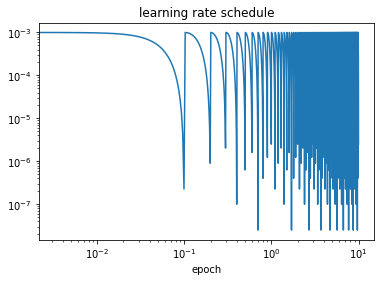

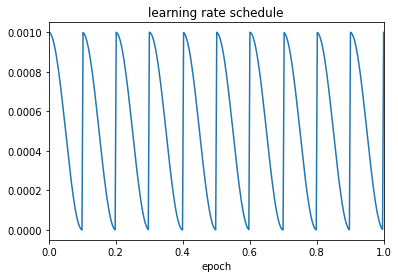

In [188]:
epochs = 10
batch_size = 32
# batch_size = 512


total_number_of_points = X_train.shape[0]

print(f"total_number_of_points (training): {total_number_of_points}")

# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/10,
    # t_mul=2.0,
    # t_mul=1.2,
    t_mul=1.,
    m_mul=1.,
    # m_mul=0.9,
    alpha=0.0,
    name=None
)


step = np.arange(0, epochs * steps_per_epoch)
lr_ = lrs(step)

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 1)
plt.show()
plt.close()



In [189]:
history={}
model={}

In [190]:
%%time
history['rff'], model['rff'] = run_model_ds(
    X_train=X_train,
    y_train=y_train,
    batch_size=batch_size,
    theta_b_scale=0.1,
    theta_input_shape=train_thetas.shape[1],
    model_type='rff',
    # model_type='plain',
    output_shape=train_hps.shape[1],
    epochs=epochs,
    threshold=1e-7,
    validation_data=(val_thetas, val_hps),
    verbose=1,
    learning_rate=lrs,
    fan_in=128,
    n_layers=6,
    units=256,
    activation='relu',
)

Epoch 1/10
313/313 [==============================] - 17s 35ms/step - loss: 3.7108e-04 - val_loss: 1.7043e-04
Epoch 2/10
313/313 [==============================] - 9s 29ms/step - loss: 1.4284e-04 - val_loss: 1.6231e-04
Epoch 3/10
313/313 [==============================] - 8s 27ms/step - loss: 1.4522e-04 - val_loss: 1.4916e-04
Epoch 4/10
313/313 [==============================] - 5s 17ms/step - loss: 1.1826e-04 - val_loss: 1.1501e-04
Epoch 5/10
313/313 [==============================] - 6s 19ms/step - loss: 1.1212e-04 - val_loss: 9.3995e-05
Epoch 6/10
313/313 [==============================] - 7s 22ms/step - loss: 7.9720e-05 - val_loss: 4.9313e-05
Epoch 7/10
313/313 [==============================] - 7s 21ms/step - loss: 7.8220e-05 - val_loss: 6.0649e-05
Epoch 8/10
313/313 [==============================] - 10s 31ms/step - loss: 5.5444e-05 - val_loss: 3.3044e-05
Epoch 9/10
313/313 [==============================] - 8s 27ms/step - loss: 4.9760e-05 - val_loss: 3.3679e-05
Epoch 10/10
313/3

In [191]:
%%time
history['plain'], model['plain'] = run_model_ds(
    X_train=X_train,
    y_train=y_train,
    batch_size=batch_size,
    theta_b_scale=1,
    theta_input_shape=train_thetas.shape[1],
    # model_type='rff',
    model_type='plain',
    output_shape=train_hps.shape[1],
    epochs=epochs,
    threshold=1e-7,
    validation_data=(val_thetas, val_hps),
    verbose=1,
    learning_rate=lrs,
    fan_in=128,
    n_layers=6,
    units=256,
    activation='relu',
)

loading best weights from checkpoint
CPU times: user 148 ms, sys: 27 ms, total: 175 ms
Wall time: 188 ms


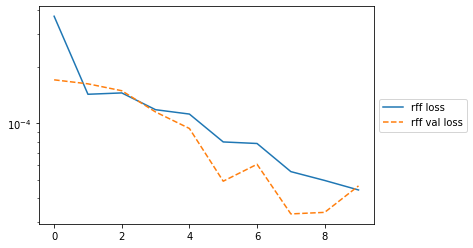

In [196]:
plt.plot(history['rff'].history['loss'], label='rff loss')
plt.plot(history['rff'].history['val_loss'], ls='--', label='rff val loss')
plt.plot(history['plain'].history['loss'], label='plain loss')
plt.plot(history['plain'].history['val_loss'], ls='--', label='plain val loss')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [197]:
train_thetas[:,1].argmax()

0

In [198]:
# idx = 5912
idx = 0

In [ ]:
train_thetas[idx]

array([1.35505083, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.74212514, 1.05145136])

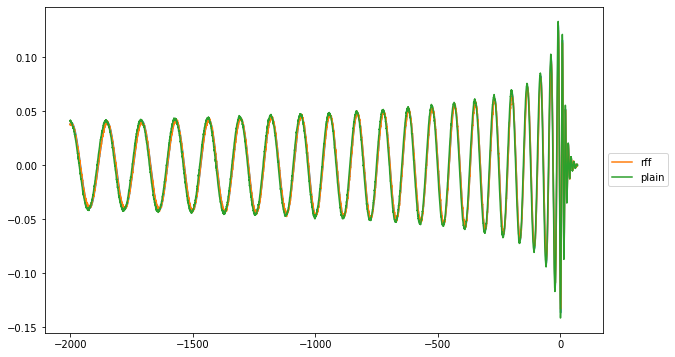

In [200]:
plt.figure(figsize=(10, 6))
plt.plot(train_times, train_hps[idx])
plt.plot(train_times, model['rff'](train_thetas[idx][np.newaxis, :])[0], label='rff')
plt.plot(train_times, model['plain'](train_thetas[idx][np.newaxis, :])[0], label='plain')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

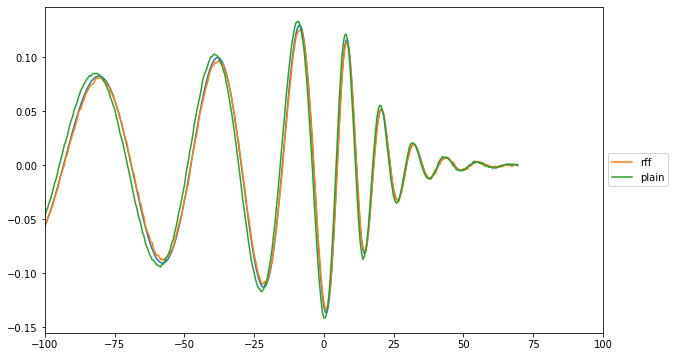

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_times, train_hps[idx])
plt.plot(train_times, model['rff'](train_thetas[idx][np.newaxis, :])[0], label='rff')
plt.plot(train_times, model['plain'](train_thetas[idx][np.newaxis, :])[0], label='plain')
plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))